# Dowscaled Climate Data Analysis


##### Three configurations were tested.

CNN consisting of 5 CNN layers (1 Conv2D, 1 MaxPooling2D, 2 Conv2DTranspose, and 1 final Conv2D) and 2 stacked LSTM layers (one returning sequences and one returning a single output).

U-Net architecture featuring 5 encoder/decoder blocks with progressively increasing filter sizes (64 to 512). It incorporated attention mechanisms, residual connections, and channel attention in the decoder path. Skip connections existed between corresponding encoder-decoder levels, and a final residual connection linked the input to the output.

Vision Transformer (ViT) architecture using patch embeddings, temporal and spatial attention layers, and transformer blocks to handle spatiotemporal data. It processes input data by embedding spatial-temporal patches, applying multi-head self-attention across both dimensions, adding positional encoding, and passing through multiple transformer layers to output a reshaped high-dimensional target prediction.

The models were trained using the daily Global Meteorological Forcing Dataset (GMFD) (https://data.ucar.edu/dataset/global-meteorological-forcing-dataset-for-land-surface-modeling) as a reference. This dataset is available at a 0.25-degree spatial resolution and covers the period 1950-2014. NEX-GDDP is also based on the same observational dataset (GMFD).

Downscaled CMIP6 data from both the CNN, U-Net and ViT models were compared with raw CMIP6 data and NEX-GDDP.

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
# Set the working directory
os.chdir('/data/keeling/a/ad87/downscale')

## Define Functions for data loading and plotting
In this section, are defined helper functions to load data, calculate statistics, and plot results.

In [2]:
import xarray as xr
import numpy as np

def load_and_mean_data(files_or_path, var_name, start_year=None, end_year=None, mask=None, lat=None, lon=None, interp_method=None, is_zarr=False):
  
    if is_zarr:
        ds = xr.open_zarr(files_or_path, consolidated=True)
    else:
        ds = xr.open_mfdataset(files_or_path, combine='by_coords', chunks={'time': -1})

    # Select time range based on start and end years
    if 'time' in ds.coords and hasattr(ds.time.dt, 'year'):
        if start_year is not None:
            ds = ds.sel(time=ds.time.dt.year >= start_year)
        if end_year is not None:
            ds = ds.sel(time=ds.time.dt.year <= end_year)
    elif start_year is not None or end_year is not None:
        print("Warning: start_year and end_year provided, but 'time' coordinate not found or doesn't have a 'year' attribute. Ignoring year selection.")


    data_mean = ds[var_name].mean(dim='time')

    # Interpolate if lat/lon are provided
    if lat is not None and lon is not None and interp_method:
        data_mean = data_mean.interp(lat=lat, lon=lon, method=interp_method, kwargs={"fill_value": "extrapolate"})

    # Apply mask if provided
    if mask is not None:
        data_mean = data_mean.where(~mask, np.nan)

    return data_mean

# Function to plot mean temperature maps
def plot_map(data, ax, title, mean_value, vmin=270, vmax=292, cmap='RdBu_r'):
    data.plot(
        ax=ax, transform=ccrs.PlateCarree(), cmap=cmap, vmin=vmin, vmax=vmax,
        cbar_kwargs={'orientation': 'horizontal', 'pad': 0.1, 'shrink': 0.8, 'aspect': 30, 'label': 'Mean Temperature (K)'}
    )
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, edgecolor='gray')
    ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', alpha=0.5, linestyle='--')
    ax.set_title(title)
    ax.text(10, 50.5, f'Mean: {mean_value:.2f} K', fontsize=10, ha='center', va='center', color='black')

# Function to calculate RMSE and MAE
def calculate_rmse_mae(model1, model2):
    diff = model1 - model2
    rmse = np.sqrt(np.nanmean(diff ** 2))
    mae = np.nanmean(np.abs(diff))
    return rmse, mae

## Load and plot historical data
Load the historical datasets (CMIP6, NEX-GDDP, CNN, U-Net), calculate the multiannual means, and plot the results.

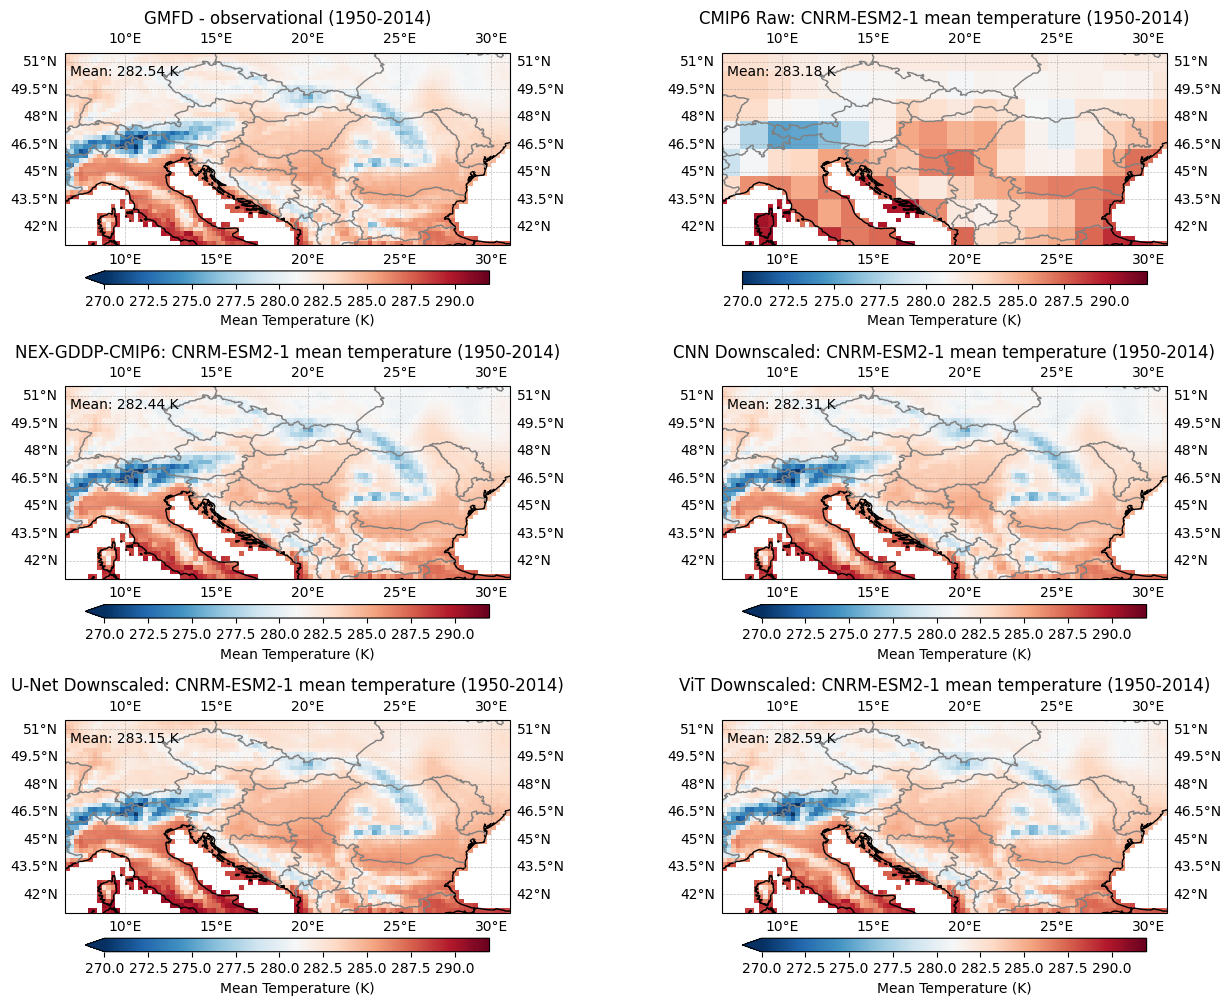

In [3]:
# Define file paths for historical data
nexgddp_base_path = '/data/keeling/a/cristi/a/downscaled_data/cmip6/nex_gddp/ncs/RO_NEX-GDDP-CMIP6/CNRM-ESM2-1'
cmip6_base_path = '/data/keeling/a/cristi/a/downscaled_data/cmip6/raw/zarr/RO_CMIP6_raw/CNRM-ESM2-1'

nexgddp_hist_files = [f'{nexgddp_base_path}/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_{year}_rou.nc' for year in range(1950, 2015)]
cmip6_hist_file = f'{cmip6_base_path}/historical/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_historical_r1i1p1f2_gr_1950_2014_rou.zarr'
cnn_hist_file = 'ncs/cnn/predicted_high_res_tas_cnnlstm.nc'
unet_hist_file = 'ncs/unet/predicted_high_res_tas_unet.nc'
vit_hist_file = 'ncs/vit/predicted_high_res_tas_vit.nc'


# Load NEX-GDDP historical data
nexgddp_mean_hist = load_and_mean_data(nexgddp_hist_files, 'tas', start_year = 1950, end_year = 2014)
mask_nexgddp_na = nexgddp_mean_hist.isnull()
target_lat, target_lon = nexgddp_mean_hist.lat, nexgddp_mean_hist.lon


# Load CMIP6 data and interpolate
cmip6_mean_hist = load_and_mean_data(cmip6_hist_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 1950, end_year = 2014)

# Load CNN and U-Net downscaled data
cnn_mean_hist = load_and_mean_data(cnn_hist_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 1950, end_year = 2014)
unet_mean_hist = load_and_mean_data(unet_hist_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 1950, end_year = 2014)
vit_mean_hist = load_and_mean_data(vit_hist_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 1950, end_year = 2014)

# Load GMFD observatinal data
gmfd_data_path = '/data/keeling/a/cristi/a/downscaled_data/gmfd/ncs/ro'
gmfd_files = [f'{gmfd_data_path}/tas_daily_ro_{year}.nc' for year in range(1950, 2015)]
gmfd_mean_hist = load_and_mean_data(gmfd_files, 'tas', mask=mask_nexgddp_na, start_year = 1950, end_year = 2014)


# Plot multiannual means for historical data
fig, axs = plt.subplots(3, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Plot each dataset for historical data
plot_map(gmfd_mean_hist, axs[0, 0], 'GMFD - observational (1950-2014)', gmfd_mean_hist.mean().values)
plot_map(cmip6_mean_hist, axs[0, 1], 'CMIP6 Raw: CNRM-ESM2-1 mean temperature (1950-2014)', cmip6_mean_hist.mean().values)
plot_map(nexgddp_mean_hist, axs[1, 0], 'NEX-GDDP-CMIP6: CNRM-ESM2-1 mean temperature (1950-2014)', nexgddp_mean_hist.mean().values)
plot_map(cnn_mean_hist, axs[1, 1], 'CNN Downscaled: CNRM-ESM2-1 mean temperature (1950-2014)', cnn_mean_hist.mean().values)
plot_map(unet_mean_hist, axs[2, 0], 'U-Net Downscaled: CNRM-ESM2-1 mean temperature (1950-2014)', unet_mean_hist.mean().values)
plot_map(vit_mean_hist, axs[2, 1], 'ViT Downscaled: CNRM-ESM2-1 mean temperature (1950-2014)', vit_mean_hist.mean().values)
# Leave axs[0, 1] empty as requested
#axs[2, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot


plt.show()

## Load and plot SSP245 scenario
The data from the SSP245 scenario for the same set of models (CMIP6, NEX-GDDP, CNN, U-Net), and plot he multiannual means for the period from 2015 to 2100.

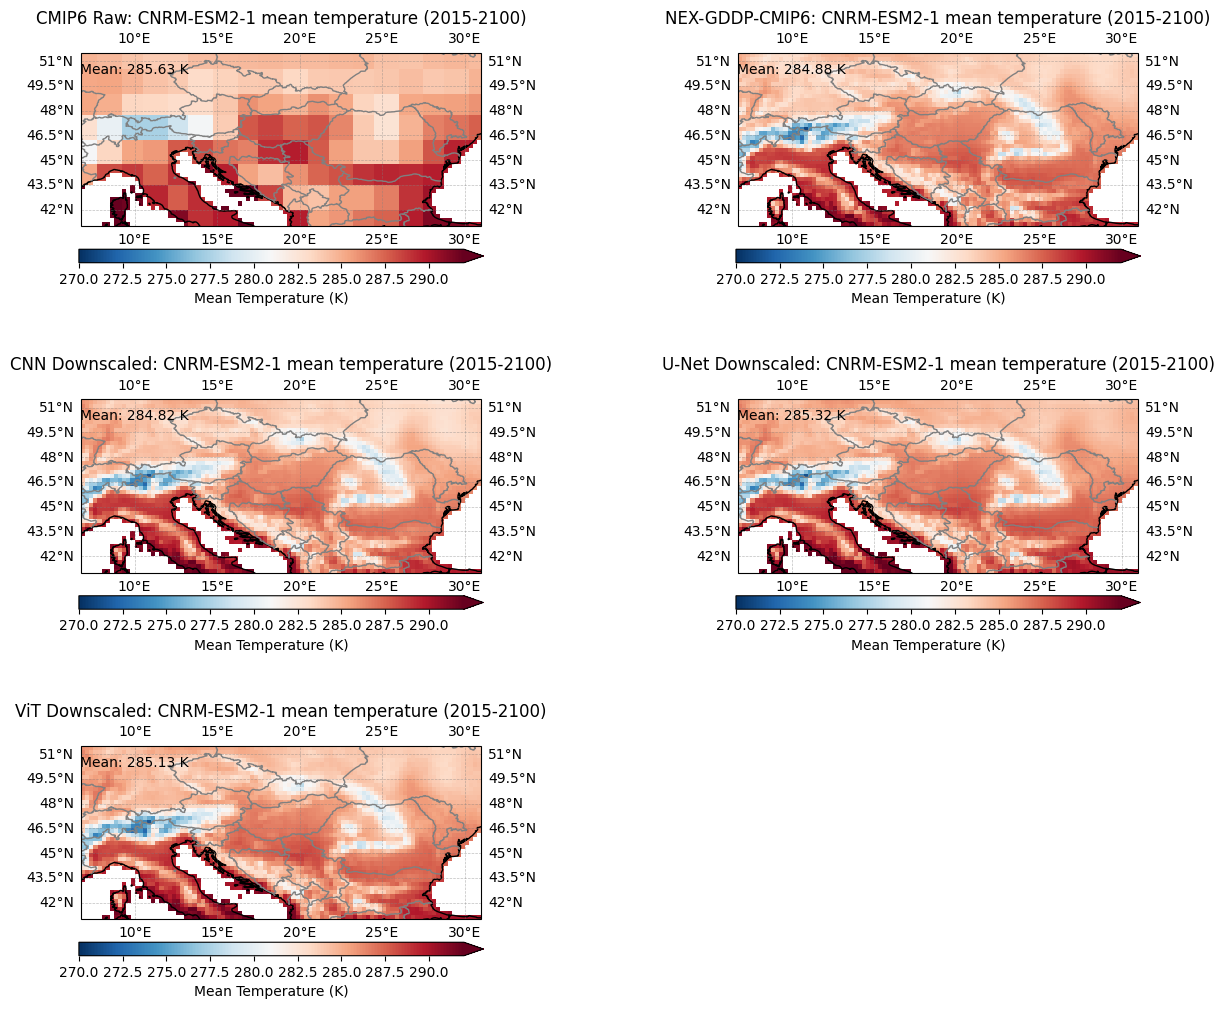

In [4]:
# Define file paths for SSP245 scenario
nexgddp_ssp_files = [f'{nexgddp_base_path}/ssp245/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_{year}_rou.nc' for year in range(2015, 2101)]
cmip6_ssp_file = f'{cmip6_base_path}/ssp245/r1i1p1f2/tas/tas_day_CNRM-ESM2-1_ssp245_r1i1p1f2_gr_2015_2100_rou.zarr'
cnn_ssp_file = 'ncs/cnn/predicted_high_res_tas_cnnlstm_ssp245.nc'
unet_ssp_file = 'ncs/unet/predicted_high_res_tas_unet_ssp245.nc'
vit_ssp_file = 'ncs/vit/predicted_high_res_tas_vit_ssp245.nc'

# Load NEX-GDDP SSP245 data
nexgddp_mean_ssp = load_and_mean_data(nexgddp_ssp_files, 'tas', start_year = 2015, end_year = 2100)
mask_nexgddp_na = nexgddp_mean_ssp.isnull()
target_lat, target_lon = nexgddp_mean_ssp.lat, nexgddp_mean_ssp.lon

# Load CMIP6 SSP245 data and interpolate
cmip6_mean_ssp = load_and_mean_data(cmip6_ssp_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 2015, end_year = 2100)

# Load CNN and U-Net downscaled data for SSP245
cnn_mean_ssp = load_and_mean_data(cnn_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2015, end_year = 2100)
unet_mean_ssp = load_and_mean_data(unet_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2015, end_year = 2100)
vit_mean_ssp = load_and_mean_data(vit_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2015, end_year = 2100)

# Plot multiannual means for SSP245 data
fig, axs = plt.subplots(3, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Plot each dataset
plot_map(cmip6_mean_ssp, axs[0, 0], 'CMIP6 Raw: CNRM-ESM2-1 mean temperature (2015-2100)', cmip6_mean_ssp.mean().values)
plot_map(nexgddp_mean_ssp, axs[0, 1], 'NEX-GDDP-CMIP6: CNRM-ESM2-1 mean temperature (2015-2100)', nexgddp_mean_ssp.mean().values)
plot_map(cnn_mean_ssp, axs[1, 0], 'CNN Downscaled: CNRM-ESM2-1 mean temperature (2015-2100)', cnn_mean_ssp.mean().values)
plot_map(unet_mean_ssp, axs[1, 1], 'U-Net Downscaled: CNRM-ESM2-1 mean temperature (2015-2100)', unet_mean_ssp.mean().values)
plot_map(vit_mean_ssp, axs[2, 0], 'ViT Downscaled: CNRM-ESM2-1 mean temperature (2015-2100)', vit_mean_ssp.mean().values)
# Leave axs[0, 1] empty as requested
axs[2, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot

plt.show()

## Plot climate change signal 

Here the changes are computed for the 2071-2100 mean against the 1981-2100.

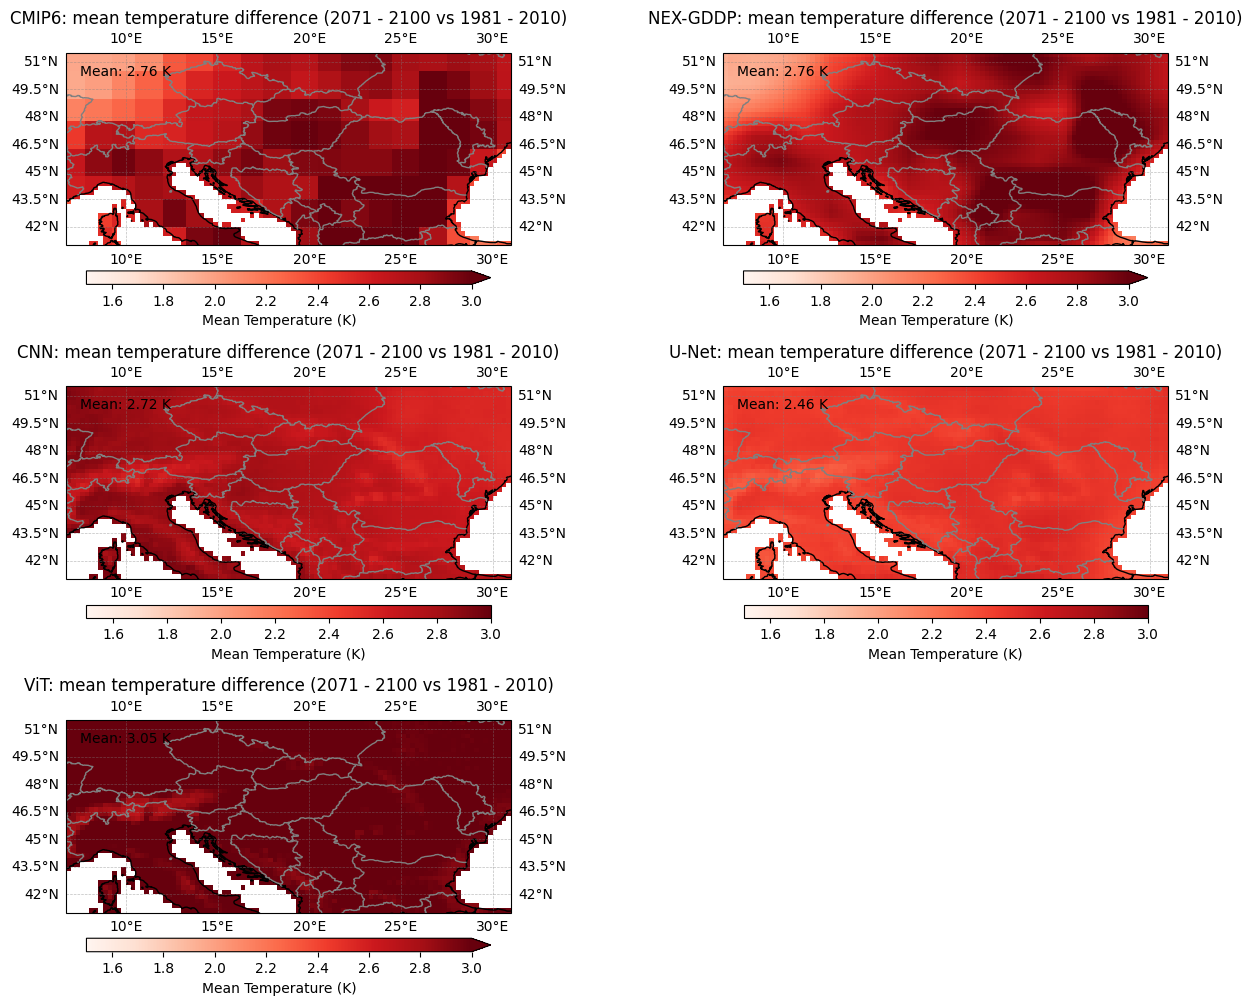

In [5]:
# Load NEX-GDDP historical data
nexgddp_mean_hist = load_and_mean_data(nexgddp_hist_files, 'tas', start_year = 1981, end_year = 2010)
mask_nexgddp_na = nexgddp_mean_hist.isnull()
target_lat, target_lon = nexgddp_mean_hist.lat, nexgddp_mean_hist.lon

# Load CMIP6 data and interpolate
cmip6_mean_hist = load_and_mean_data(cmip6_hist_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 1981, end_year = 2010)

# Load CNN and U-Net downscaled data
cnn_mean_hist = load_and_mean_data(cnn_hist_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 1981, end_year = 2010)
unet_mean_hist = load_and_mean_data(unet_hist_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 1981, end_year = 2010)

# Load NEX-GDDP SSP245 data
nexgddp_mean_ssp = load_and_mean_data(nexgddp_ssp_files, 'tas', start_year = 2071, end_year = 2100)
mask_nexgddp_na = nexgddp_mean_ssp.isnull()
target_lat, target_lon = nexgddp_mean_ssp.lat, nexgddp_mean_ssp.lon

# Load CMIP6 SSP245 data and interpolate
cmip6_mean_ssp = load_and_mean_data(cmip6_ssp_file, 'tas', mask=mask_nexgddp_na, lat=target_lat, lon=target_lon, interp_method='nearest', is_zarr=True, start_year = 2071, end_year = 2100)

# Load CNN and U-Net downscaled data for SSP245
cnn_mean_ssp = load_and_mean_data(cnn_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2071, end_year = 2100)
unet_mean_ssp = load_and_mean_data(unet_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2071, end_year = 2100)
vit_mean_ssp = load_and_mean_data(vit_ssp_file, 'tas_downscaled', mask=mask_nexgddp_na, start_year = 2071, end_year = 2100)

cmip6_change = cmip6_mean_ssp - cmip6_mean_hist
nexgddp_mean_change = nexgddp_mean_ssp - nexgddp_mean_hist
cnn_mean_change = cnn_mean_ssp - cnn_mean_hist
unet_mean_change = unet_mean_ssp - unet_mean_hist
vit_mean_change = vit_mean_ssp - vit_mean_hist

# Plot changes for SSP245
fig, axs = plt.subplots(3, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
# Adjust subplot spacing more tightly
fig.subplots_adjust(hspace=0.3, wspace=0.3)  # Negative hspace reduces vertical space

# Plot changes 2071 - 2100 vs 1981 - 2010
plot_map(cmip6_change, axs[0, 0], 'CMIP6: mean temperature difference (2071 - 2100 vs 1981 - 2010)', cmip6_change.mean().values, vmin=1.5, vmax=3, cmap='Reds')
plot_map(nexgddp_mean_change, axs[0, 1], 'NEX-GDDP: mean temperature difference (2071 - 2100 vs 1981 - 2010)', nexgddp_mean_change.mean().values, vmin=1.5, vmax=3, cmap='Reds')
plot_map(cnn_mean_change, axs[1, 0], 'CNN: mean temperature difference (2071 - 2100 vs 1981 - 2010)', cnn_mean_change.mean().values, vmin=1.5, vmax=3, cmap='Reds')
plot_map(unet_mean_change, axs[1, 1], 'U-Net: mean temperature difference (2071 - 2100 vs 1981 - 2010)', unet_mean_change.mean().values, vmin=1.5, vmax=3, cmap='Reds')
plot_map(vit_mean_change, axs[2, 0], 'ViT: mean temperature difference (2071 - 2100 vs 1981 - 2010)', vit_mean_change.mean().values, vmin=1.5, vmax=3, cmap='Reds')
axs[2, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot

plt.show()

## Plot differences for SSP245 data
Calculate the differences between the CMIP6 and the NEX-GDDP, CNN, U-Net and ViT for the SSP245 scenario.

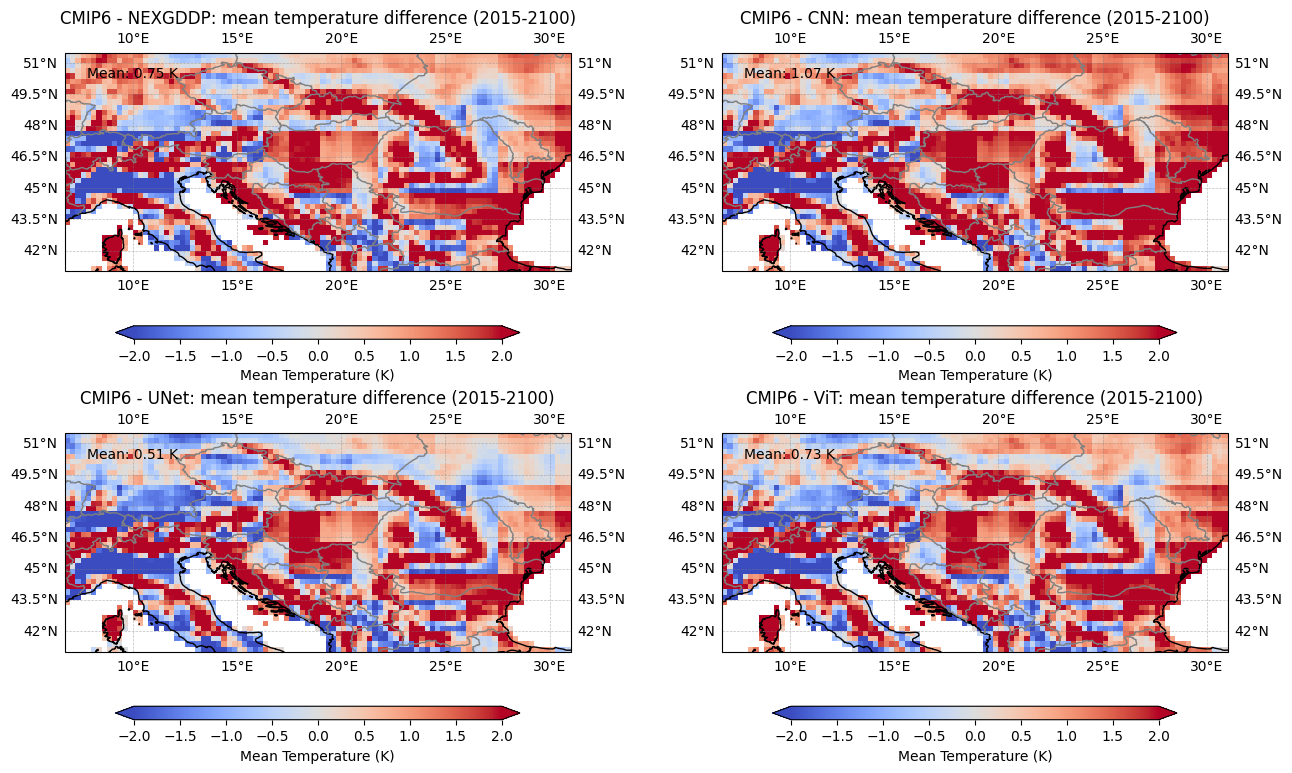

In [6]:
# Plot differences for SSP245

# Calculate and plot differences
nexgddp_diff_ssp = cmip6_mean_ssp - nexgddp_mean_ssp
cnn_diff_ssp = cmip6_mean_ssp - cnn_mean_ssp
unet_diff_ssp = cmip6_mean_ssp - unet_mean_ssp
vit_diff_ssp = cmip6_mean_ssp - vit_mean_ssp

# Plot changes for SSP245
fig, axs = plt.subplots(2, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=-0.3, wspace=0.3)
# Plot difference: CMIP6 - NEXGDDP
plot_map(nexgddp_diff_ssp, axs[0,0], 'CMIP6 - NEXGDDP: mean temperature difference (2015-2100)', nexgddp_diff_ssp.mean().values, vmin=-2, vmax=2, cmap='coolwarm')

# Plot difference: CMIP6 - CNN
plot_map(cnn_diff_ssp, axs[0,1], 'CMIP6 - CNN: mean temperature difference (2015-2100)', cnn_diff_ssp.mean().values, vmin=-2, vmax=2, cmap='coolwarm')

# Plot difference: CMIP6 - UNet
plot_map(unet_diff_ssp, axs[1,0], 'CMIP6 - UNet: mean temperature difference (2015-2100)', unet_diff_ssp.mean().values, vmin=-2, vmax=2, cmap='coolwarm')
plot_map(vit_diff_ssp, axs[1,1], 'CMIP6 - ViT: mean temperature difference (2015-2100)', vit_diff_ssp.mean().values, vmin=-2, vmax=2, cmap='coolwarm')


# Leave axs[1, 0] empty as requested
#axs[0, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot

plt.show()

## Calculate RMSE and MAE for SSP245 and plot time series of the annual and montly global mean for the selected domain
Calculate the RMSE and MAE between the downscaled models (NEX-GDDP, CNN, U-Net) and the CMIP6 raw data for the SSP245 scenario, for yearly data for all pixels from the domain.

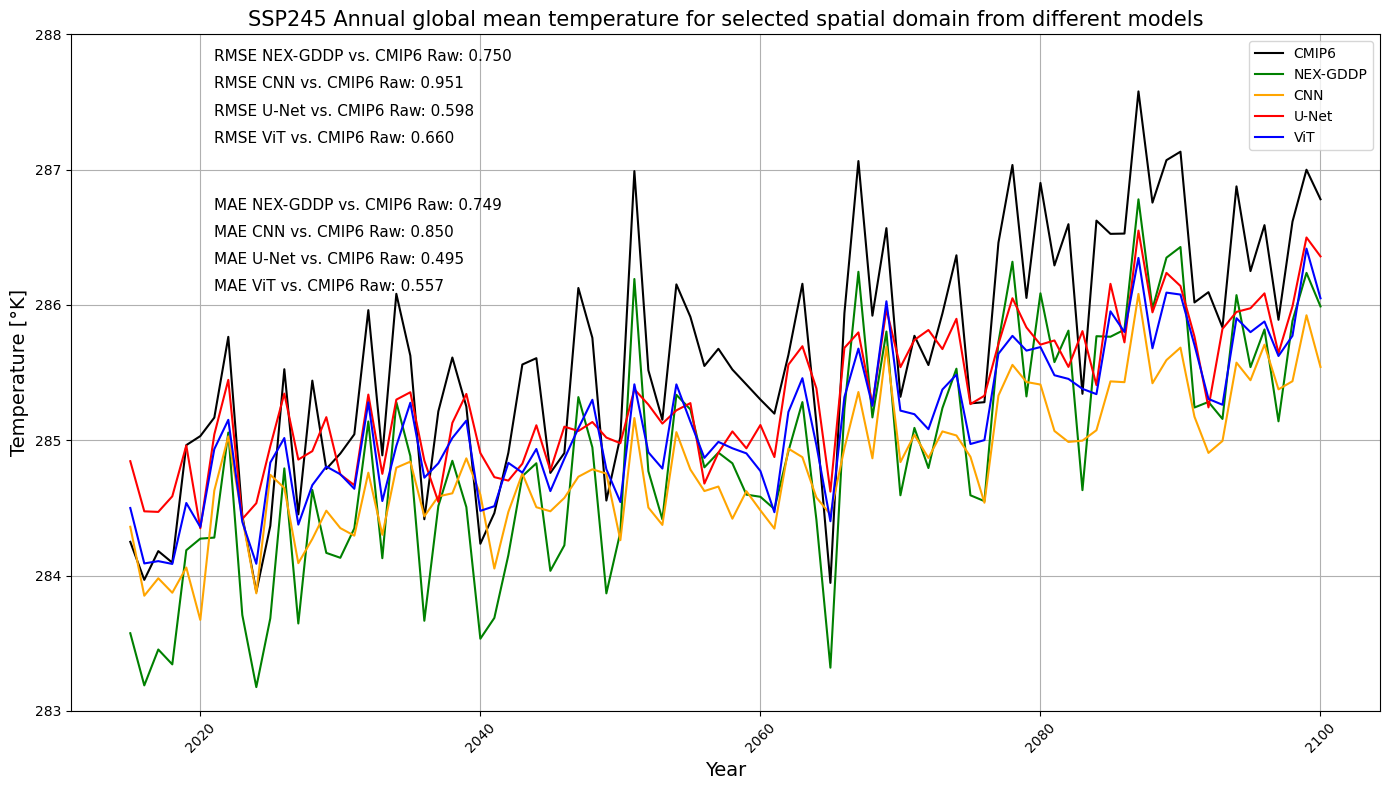

RMSE and MAE values:
NEX-GDDP: RMSE = 0.750, MAE = 0.749
CNN: RMSE = 0.951, MAE = 0.850
U-Net: RMSE = 0.598, MAE = 0.495
ViT: RMSE = 0.660, MAE = 0.557


In [7]:
import dask
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt

# Set up dask for parallel processing
dask.config.set(scheduler='threads', num_workers=4)  # Adjust num_workers as needed

# Load NEX-GDDP data
nexgddp_ds = xr.open_mfdataset(nexgddp_ssp_files, combine='by_coords', chunks={'time': 365, 'lat': 100, 'lon': 100})
nexgddp_annual = nexgddp_ds['tas'].resample(time='YE').mean(dim='time')
nexgddp_global_mean = nexgddp_annual.mean(dim=['lat', 'lon'])
mask_nexgddp_na = nexgddp_annual.isnull()

# Load CMIP6 data 
cmip6_ds = xr.open_zarr(cmip6_ssp_file, consolidated=True)
cmip6_ds = cmip6_ds.interp(lat=nexgddp_ds['lat'], lon=nexgddp_ds['lon'], method='nearest',  kwargs={"fill_value": "extrapolate"})

cmip6_annual = cmip6_ds['tas'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
cmip6_global_mean = cmip6_annual.mean(dim=['lat', 'lon'])

# Load and process CNN data
cnn_ds = xr.open_dataset(cnn_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
cnn_annual = cnn_ds['tas_downscaled'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
cnn_global_mean = cnn_annual.mean(dim=['lat', 'lon'])

# Load and process U-Net data
unet_ds = xr.open_dataset(unet_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
unet_annual = unet_ds['tas_downscaled'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
unet_global_mean = unet_annual.mean(dim=['lat', 'lon'])

# Load and process ViT data
vit_ds = xr.open_dataset(vit_ssp_file, chunks={'time': 365, 'lat': 100, 'lon': 100})
vit_annual = vit_ds['tas_downscaled'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na)
vit_global_mean = vit_annual.mean(dim=['lat', 'lon'])

# Calculate RMSE and MAE values
def calculate_rmse_mae(actual, predicted):
    valid_mask = ~np.isnan(actual) & ~np.isnan(predicted)
    actual_valid = actual[valid_mask]
    predicted_valid = predicted[valid_mask]
    
    if len(actual_valid) == 0:
        return np.nan, np.nan
    
    rmse = np.sqrt(((actual_valid - predicted_valid) ** 2).mean())
    mae = np.abs(actual_valid - predicted_valid).mean()
    return rmse, mae

# Compute all values
results = dask.compute(nexgddp_global_mean, cmip6_global_mean, cnn_global_mean, unet_global_mean,vit_global_mean,
                       calculate_rmse_mae(cmip6_global_mean.values, nexgddp_global_mean.values),
                       calculate_rmse_mae(cmip6_global_mean.values, cnn_global_mean.values),
                       calculate_rmse_mae(cmip6_global_mean.values, unet_global_mean.values),
                      calculate_rmse_mae(cmip6_global_mean.values, vit_global_mean.values))

nexgddp_global_mean, cmip6_global_mean, cnn_global_mean, unet_global_mean, vit_global_mean, \
(rmse_nexgddp, mae_nexgddp), (rmse_cnn, mae_cnn), (rmse_unet, mae_unet), (rmse_vit, mae_vit) = results

# Prepare for plotting
years = cmip6_global_mean['time.year'].values

plt.figure(figsize=(14, 8))

# Plot each model's global mean
plt.plot(years, cmip6_global_mean.values, label='CMIP6', color='black')
plt.plot(years, nexgddp_global_mean.values, label='NEX-GDDP', color='green')
plt.plot(years, cnn_global_mean.values, label='CNN', color='orange')
plt.plot(years, unet_global_mean.values, label='U-Net', color='red')
plt.plot(years, vit_global_mean.values, label='ViT', color='blue')

# Customize the plot
plt.title('SSP245 Annual global mean temperature for selected spatial domain from different models', fontsize=15)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Temperature [°K]', fontsize=14)
plt.legend()
plt.grid()
plt.xticks(rotation=45)

# Adjust text_y_positions to have enough elements
text_y_positions = [287.8, 287.6, 287.4, 287.2, 286.7, 286.5, 286.3, 286.1]

for i, (rmse, mae, label) in enumerate(zip(
        [rmse_nexgddp, rmse_cnn, rmse_unet, rmse_vit],
        [mae_nexgddp, mae_cnn, mae_unet, mae_vit],
        ['NEX-GDDP', 'CNN', 'U-Net', 'ViT'])):
    if np.isnan(rmse) or np.isnan(mae):
        plt.text(2021, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
        plt.text(2021, text_y_positions[i+4], f'MAE {label} vs. CMIP6 Raw: Unable to calculate', fontsize=11)
    else:
        plt.text(2021, text_y_positions[i], f'RMSE {label} vs. CMIP6 Raw: {rmse:.3f}', fontsize=11)
        plt.text(2021, text_y_positions[i+4], f'MAE {label} vs. CMIP6 Raw: {mae:.3f}', fontsize=11)


# Adjust subplot parameters for better layout
plt.ylim(283, 288)
plt.tight_layout()
plt.show()

# Print additional information
print("RMSE and MAE values:")
print(f"NEX-GDDP: RMSE = {rmse_nexgddp:.3f}, MAE = {mae_nexgddp:.3f}")
print(f"CNN: RMSE = {rmse_cnn:.3f}, MAE = {mae_cnn:.3f}")
print(f"U-Net: RMSE = {rmse_unet:.3f}, MAE = {mae_unet:.3f}")
print(f"ViT: RMSE = {rmse_vit:.3f}, MAE = {mae_vit:.3f}")

/data/keeling/a/ad87/miniconda3/envs/ml/lib/python3.10/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'netcdf4' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/data/keeling/a/ad87/miniconda3/envs/ml/lib/python3.10/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'h5netcdf' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/data/keeling/a/ad87/miniconda3/envs/ml/lib/python3.10/site-packages/xarray/backends/api.py:652: RuntimeWarning: 'scipy' fails while guessing
  engine = plugins.guess_engine(filename_or_obj)
/data/keeling/a/ad87/miniconda3/envs/ml/lib/python3.10/site-packages/xarray/backends/api.py:365: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 365. This could degrade performance. Instead, consider rechunking after loading.
  var_chunks = _get_chunk(var, chunks, chunkmanager)


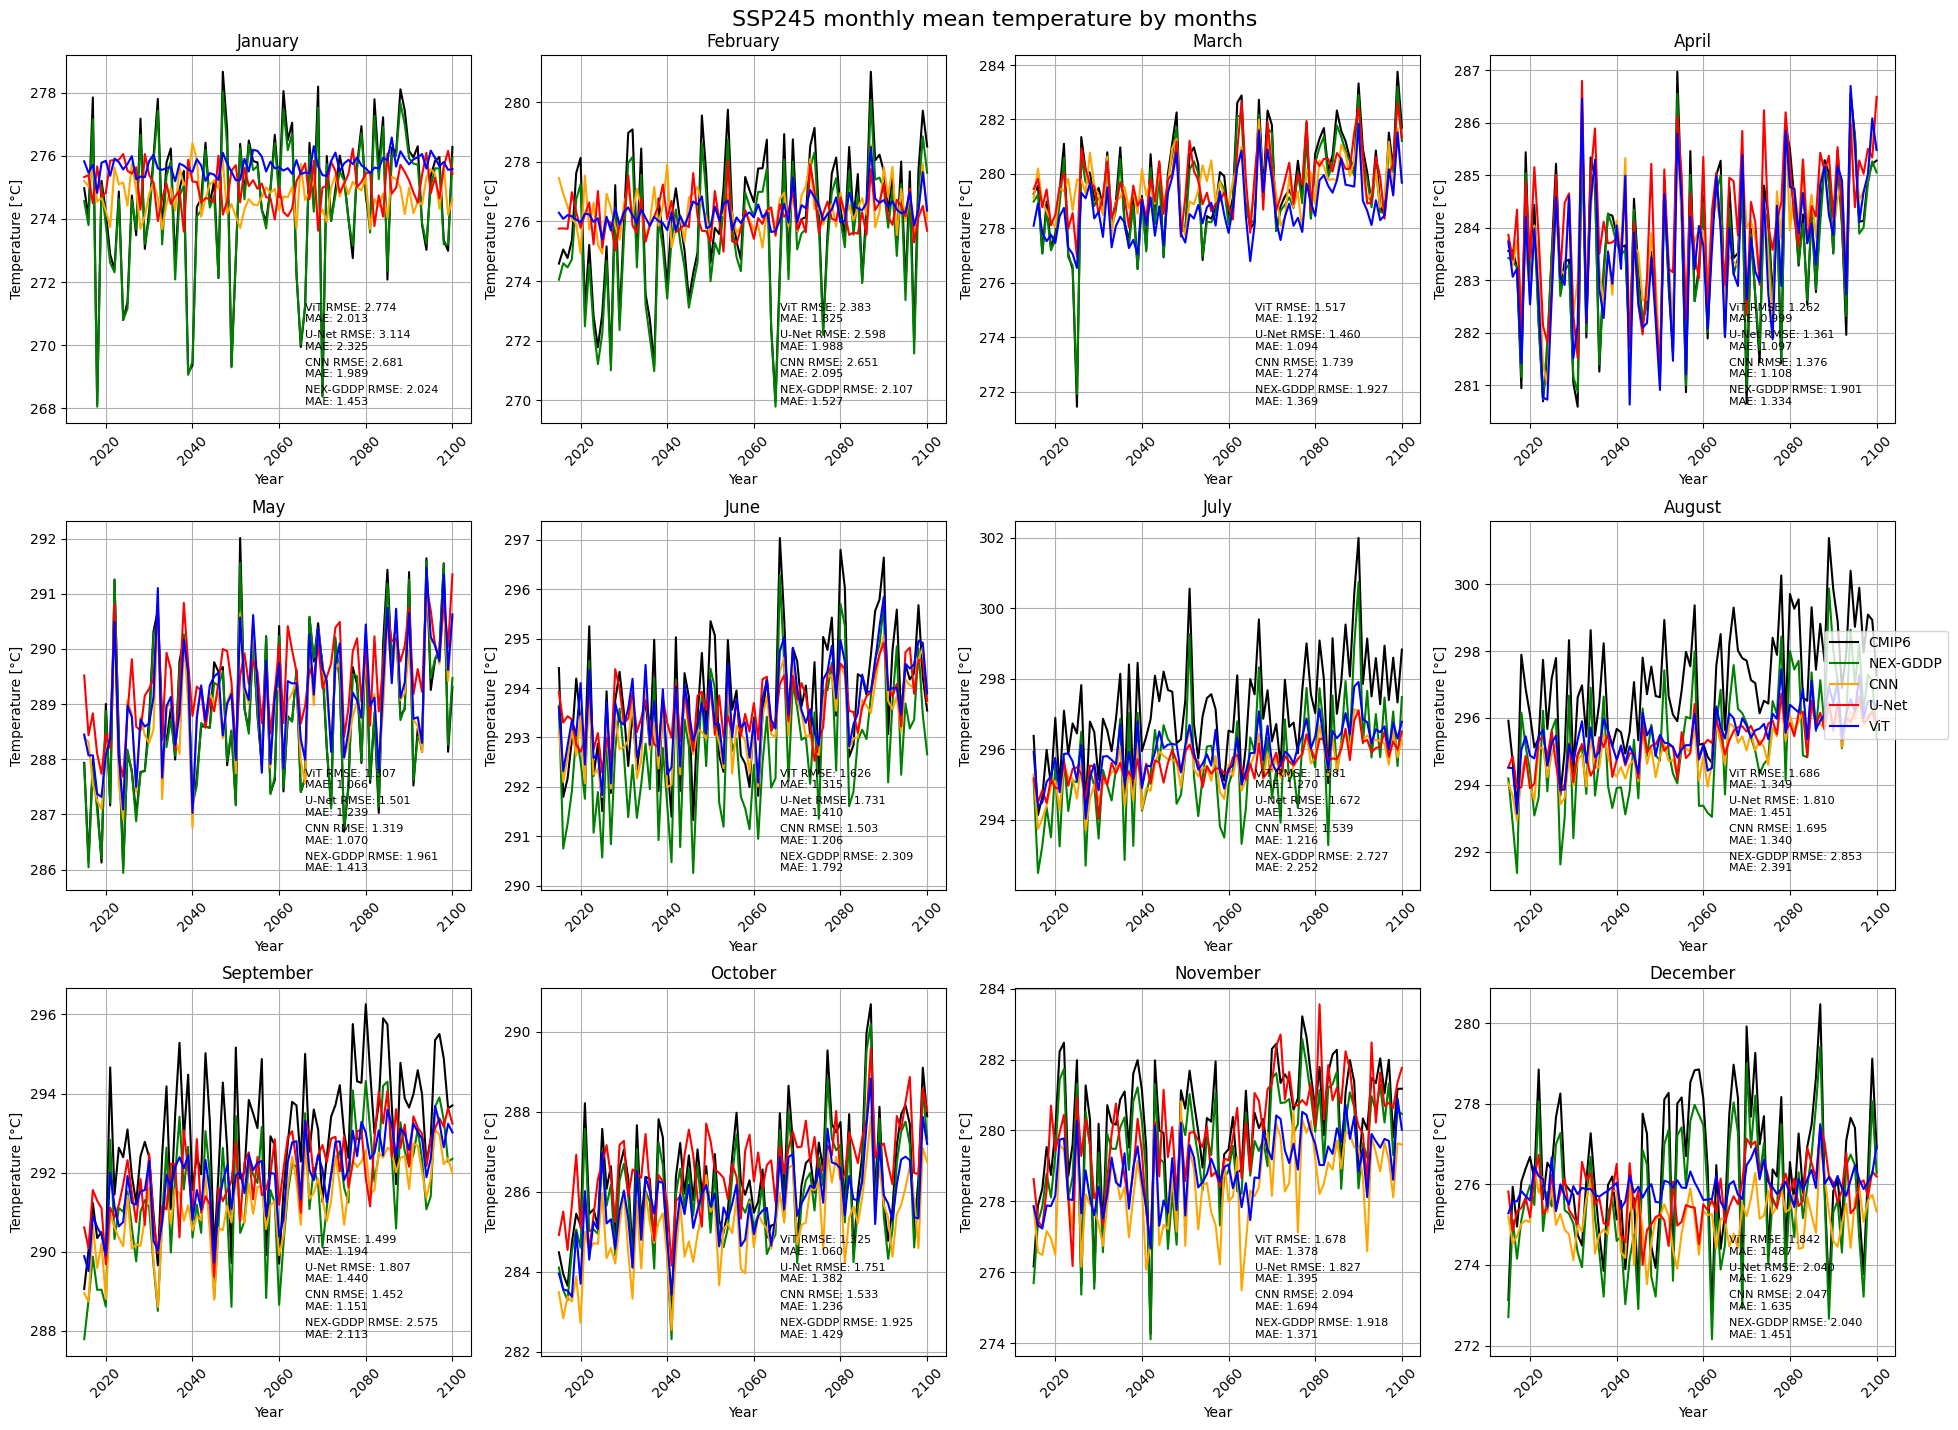

In [8]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import dask.array as da

# Function to calculate RMSE and MAE
def calculate_rmse_mae(true, pred):
    diff = true - pred
    rmse = np.sqrt(np.nanmean(diff ** 2))
    mae = np.nanmean(np.abs(diff))
    return rmse, mae

# Load and process data
def load_and_process(file_pattern, var_name='tas', chunks={'time': 365}):
    ds = xr.open_mfdataset(file_pattern, combine='by_coords', chunks=chunks)
    monthly = ds[var_name].resample(time='ME').mean(dim='time')
    return monthly

nexgddp_monthly = load_and_process(nexgddp_ssp_files)
cmip6_monthly = load_and_process(cmip6_ssp_file)
cnn_monthly = load_and_process(cnn_ssp_file, var_name='tas_downscaled')
unet_monthly = load_and_process(unet_ssp_file, var_name='tas_downscaled')
vit_monthly = load_and_process(vit_ssp_file, var_name='tas_downscaled')

# Interpolate CMIP6 data
cmip6_monthly = cmip6_monthly.interp(lat=nexgddp_monthly['lat'], lon=nexgddp_monthly['lon'], method='nearest')
mask_nexgddp_na = nexgddp_monthly.isnull()

# Apply mask to all datasets
datasets = [cmip6_monthly,nexgddp_monthly, cnn_monthly, unet_monthly, vit_monthly]
datasets = [ds.where(~mask_nexgddp_na, np.nan) for ds in datasets]
# Convert temperatures from Kelvin to Celsius (vectorized operation)
#datasets = [ds - 273.15 for ds in datasets]


cmip6_global_mean_monthly = datasets[0].mean(dim=['lat', 'lon'])
nexgddp_global_mean_monthly = datasets[1].mean(dim=['lat', 'lon'])
cnn_global_mean_monthly = datasets[2].mean(dim=['lat', 'lon'])
unet_global_mean_monthly =  datasets[3].mean(dim=['lat', 'lon'])
vit_global_mean_monthly =  datasets[4].mean(dim=['lat', 'lon'])


global_means = [cmip6_global_mean_monthly, nexgddp_global_mean_monthly, cnn_global_mean_monthly, unet_global_mean_monthly, vit_global_mean_monthly]

# Precompute years and months
years = cmip6_global_mean_monthly['time.year'].values
months = ['January', 'February', 'March', 'April', 'May', 'June',
          'July', 'August', 'September', 'October', 'November', 'December']

# Create subplots
plt.style.use('default')
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
axes_flat = axes.flatten()

# Plot data and calculate metrics
for month_idx, (ax, month) in enumerate(zip(axes_flat, months), 1):
    month_mask = cmip6_global_mean_monthly['time.month'] == month_idx
    
    for gm, label, color in zip(global_means, ['CMIP6', 'NEX-GDDP', 'CNN', 'U-Net', 'ViT'], ['black', 'green', 'orange', 'red', 'blue']):
        ax.plot(years[month_mask], gm.values[month_mask], label=label, color=color)
    
    rmse_nexgddp, mae_nexgddp = calculate_rmse_mae(datasets[1].values[month_mask], datasets[0].values[month_mask])
    rmse_cnn, mae_cnn = calculate_rmse_mae(datasets[1].values[month_mask], datasets[2].values[month_mask])
    rmse_unet, mae_unet = calculate_rmse_mae(datasets[1].values[month_mask], datasets[3].values[month_mask])
    rmse_vit, mae_vit = calculate_rmse_mae(datasets[1].values[month_mask], datasets[4].values[month_mask])
    
    ax.set_title(f'{month}', fontsize=12)
    ax.set_xlabel('Year', fontsize=10)
    ax.set_ylabel('Temperature [°C]', fontsize=10)
    ax.grid(True)
    ax.tick_params(axis='x', rotation=45)
    
    y_min, y_max = ax.get_ylim()
    text_spacing = (y_max - y_min) * 0.05
    base_y = y_min + text_spacing
    
    for i, (rmse, mae, label) in enumerate(zip(
            [rmse_nexgddp, rmse_cnn, rmse_unet, rmse_vit],
            [mae_nexgddp, mae_cnn, mae_unet, mae_vit],
            ['NEX-GDDP', 'CNN', 'U-Net', 'ViT'])):
        ax.text(2066, base_y + i*text_spacing*1.5, 
                f'{label} RMSE: {rmse:.3f}\nMAE: {mae:.3f}', 
                fontsize=8)

# Finalize plot
handles, labels = axes_flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', bbox_to_anchor=(0.98, 0.5))
fig.suptitle('SSP245 monthly mean temperature by months', fontsize=16, y=0.95)
plt.tight_layout()
#plt.ylim(260,285)
plt.subplots_adjust(right=0.95, top=0.92)
plt.show()

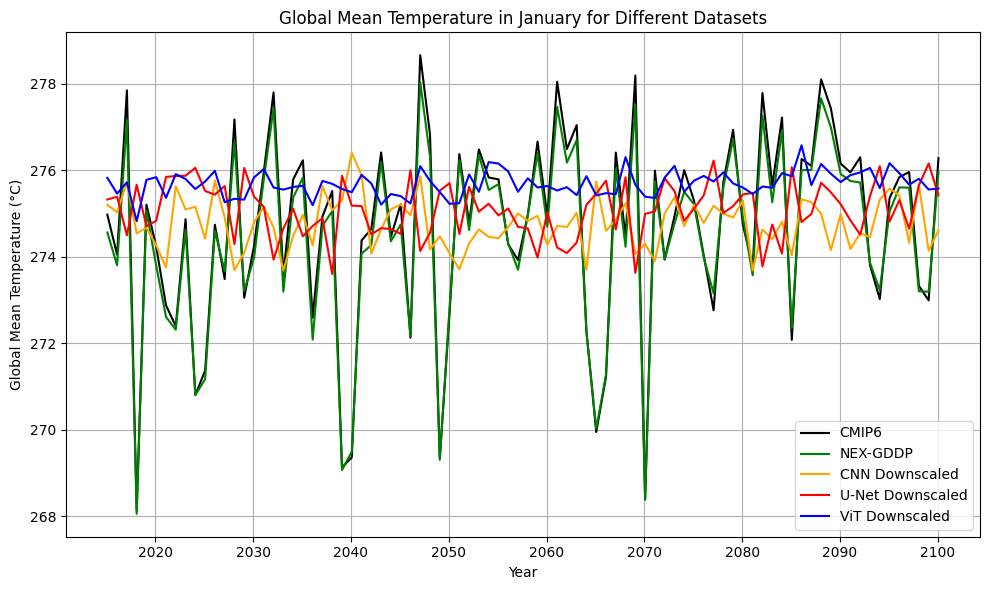

In [9]:
# Extract January data from each dataset
cmip6_january = cmip6_global_mean_monthly.sel(time=cmip6_global_mean_monthly['time.month'] == 1)
nexgddp_january = nexgddp_global_mean_monthly.sel(time=nexgddp_global_mean_monthly['time.month'] == 1)
cnn_january = cnn_global_mean_monthly.sel(time=cnn_global_mean_monthly['time.month'] == 1)
unet_january = unet_global_mean_monthly.sel(time=unet_global_mean_monthly['time.month'] == 1)
vit_january = vit_global_mean_monthly.sel(time=vit_global_mean_monthly['time.month'] == 1)

# Prepare plot
plt.figure(figsize=(10, 6))

# Plot each dataset's global mean for January
plt.plot(cmip6_january['time'], cmip6_january, label='CMIP6', color='black')
plt.plot(nexgddp_january['time'], nexgddp_january, label='NEX-GDDP',color='green')
plt.plot(cnn_january['time'], cnn_january, label='CNN Downscaled', color='orange')
plt.plot(unet_january['time'], unet_january, label='U-Net Downscaled', color='red')
plt.plot(vit_january['time'], vit_january, label='ViT Downscaled', color='blue')

# Add labels, legend, and title
plt.xlabel('Year')
plt.ylabel('Global Mean Temperature (°C)')
plt.title('Global Mean Temperature in January for Different Datasets')
plt.legend()
plt.grid(True)

# Show the plot
plt.tight_layout()
plt.show()


##### Print accuracy metrics

In [10]:
import pandas as pd

# Create a dictionary to store the metrics for each month
metrics = {
    "Month": [],
    "NEX-GDDP RMSE": [],
    "CNN RMSE": [],
    "U-Net RMSE": [],
    "ViT RMSE": [],
    "NEX-GDDP MAE": [],
    "CNN MAE": [],
    "U-Net MAE": [],
    "ViT MAE": []
}

# Plot data and calculate metrics
for month_idx, month in enumerate(months, 1):
    month_mask = cmip6_global_mean_monthly['time.month'] == month_idx
    
    # Calculate RMSE and MAE for each model
    rmse_nexgddp, mae_nexgddp = calculate_rmse_mae(datasets[1].values[month_mask], datasets[0].values[month_mask])
    rmse_cnn, mae_cnn = calculate_rmse_mae(datasets[1].values[month_mask], datasets[2].values[month_mask])
    rmse_unet, mae_unet = calculate_rmse_mae(datasets[1].values[month_mask], datasets[3].values[month_mask])
    rmse_vit, mae_vit = calculate_rmse_mae(datasets[1].values[month_mask], datasets[4].values[month_mask])
    
    # Add the metrics for this month to the dictionary
    metrics["Month"].append(month)
    metrics["NEX-GDDP RMSE"].append(rmse_nexgddp)
    metrics["NEX-GDDP MAE"].append(mae_nexgddp)
    metrics["CNN RMSE"].append(rmse_cnn)
    metrics["CNN MAE"].append(mae_cnn)
    metrics["U-Net RMSE"].append(rmse_unet)
    metrics["U-Net MAE"].append(mae_unet)
    metrics["ViT RMSE"].append(rmse_vit)
    metrics["ViT MAE"].append(mae_vit)

# Convert the metrics dictionary to a Pandas DataFrame
metrics_df = pd.DataFrame(metrics)

# Separate RMSE and MAE into two different tables
rmse_df = metrics_df[['Month', 'NEX-GDDP RMSE', 'CNN RMSE', 'U-Net RMSE', 'ViT RMSE']]
mae_df = metrics_df[['Month', 'NEX-GDDP MAE', 'CNN MAE', 'U-Net MAE', 'ViT MAE']]

# Round the values to 3 decimal places for better presentation
rmse_df = rmse_df.round(3)
mae_df = mae_df.round(3)

# Improve formatting for scientific paper style
def format_table(df, title):
    table_str = f"{title}\n"
    table_str += df.to_string(index=False, col_space=15, justify='center')
    return table_str

# Display the RMSE and MAE tables
rmse_table_str = format_table(rmse_df, "Table 1: Root Mean Squared Error (RMSE) by Model and Month")
mae_table_str = format_table(mae_df, "Table 2: Mean Absolute Error (MAE) by Model and Month")

# Print the formatted tables
print(rmse_table_str)
print("\n" + mae_table_str)

Table 1: Root Mean Squared Error (RMSE) by Model and Month
     Month        NEX-GDDP RMSE     CNN RMSE       U-Net RMSE       ViT RMSE   
     January         2.024           2.681           3.114           2.774     
    February         2.107           2.651           2.598           2.383     
       March         1.927           1.739           1.460           1.517     
       April         1.901           1.376           1.361           1.262     
         May         1.961           1.319           1.501           1.307     
        June         2.309           1.503           1.731           1.626     
        July         2.727           1.539           1.672           1.581     
      August         2.853           1.695           1.810           1.686     
   September         2.575           1.452           1.807           1.499     
     October         1.925           1.533           1.751           1.325     
    November         1.918           2.094           1.827   

##### Plot January 2015

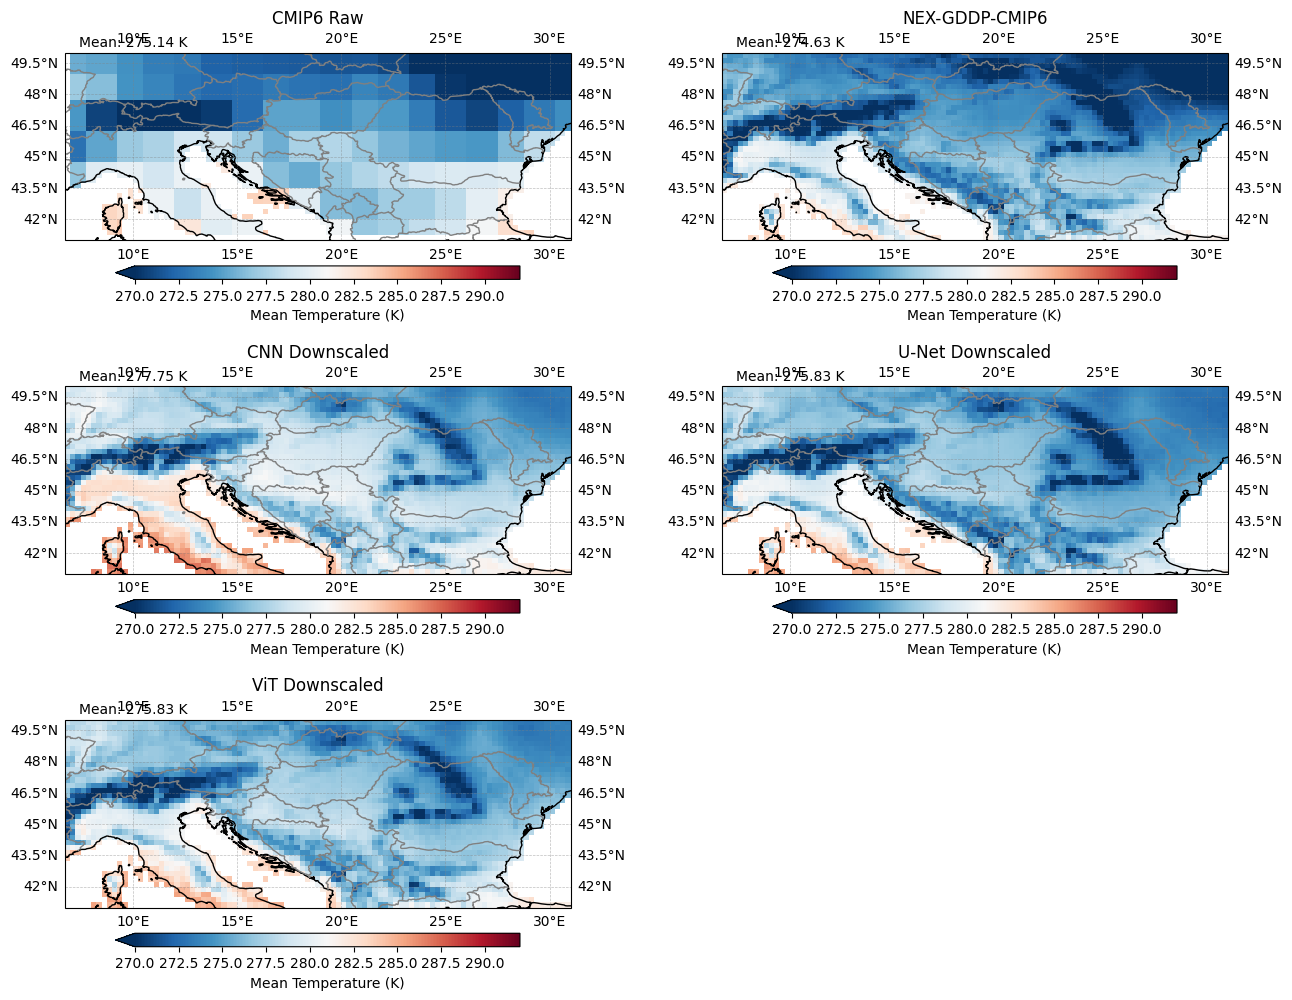

In [11]:
import dask
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt


lat_subset = slice(30, 50)
datasets_subset = [ds.sel(lat=lat_subset) for ds in datasets]

# Find the index for the year 2050
year_2050_index = 1

# Plot multiannual means for SSP245 data
fig, axs = plt.subplots(3, 2, figsize=(15, 12), subplot_kw={'projection': ccrs.PlateCarree()})
fig.subplots_adjust(hspace=0.3, wspace=0.3)

# Plot each dataset
plot_map(datasets_subset[0].isel(time=year_2050_index), axs[0, 0], 'CMIP6 Raw',datasets_subset[0].isel(time=year_2050_index).mean().values)
plot_map(datasets_subset[1].isel(time=year_2050_index), axs[0, 1], 'NEX-GDDP-CMIP6', datasets_subset[1].isel(time=year_2050_index).mean().values)
plot_map(datasets_subset[2].isel(time=year_2050_index), axs[1, 0], 'CNN Downscaled', datasets_subset[2].isel(time=year_2050_index).mean().values)
plot_map(datasets_subset[3].isel(time=year_2050_index), axs[1, 1], 'U-Net Downscaled', datasets_subset[3].isel(time=year_2050_index).mean().values)
plot_map(datasets_subset[4].isel(time=year_2050_index), axs[2, 0], 'ViT Downscaled', datasets_subset[3].isel(time=year_2050_index).mean().values)
axs[2, 1].set_axis_off()  # This explicitly turns off the axes for the empty plot


### Next steps

Evaluate the methods using all available CMIP6 scenarios.

Adapt the models for multi-variable climate downscaling within a single realization - dowscale temperature and precipitation at the same time.

Other architectures found in the literature to be tested: ViT (vision transformers adapted for climate data), advanced CNN variants (ResNet with deconvolution layers), GANs (Generative Adversarial Networks).

In [12]:
gmfd_data_resize

NameError: name 'gmfd_data_resize' is not defined

In [ ]:
cmip6_data

In [ ]:
# Load and process U-Net data
nexgddp_ds = xr.open_mfdataset(nexgddp_ssp_files, combine='by_coords', chunks={'time': 365})
nexgddp_annual = nexgddp_ds['tas'].resample(time='YE').mean(dim='time')
nexgddp_global_mean = nexgddp_annual.mean(dim=['lat', 'lon'])
mask_nexgddp_na = nexgddp_annual.isnull()
unet_ds = xr.open_dataset(unet_ssp_file)
unet_annual = unet_ds['tas_downscaled'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na, np.nan)
unet_global_mean = unet_annual.mean(dim=['lat', 'lon'])
# Load and process CNN data
cnn_ds = xr.open_dataset(cnn_ssp_file, chunks={'time': 365})
cnn_annual = cnn_ds['tas_downscaled'].resample(time='YE').mean(dim='time').where(~mask_nexgddp_na, np.nan)
cnn_global_mean = cnn_annual.mean(dim=['lat', 'lon'])

In [ ]:
cnn_global_mean.values

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import keras
from keras import ops
from keras.layers import (
    Input, Dense, Dropout, MultiHeadAttention, LayerNormalization,
    Add, Layer, Conv3D, Reshape, GlobalAveragePooling3D
)
from keras.models import Model
import numpy as np




@tf.keras.utils.register_keras_serializable()
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, mlp_dim, dropout=0.1, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.mlp_dim = mlp_dim
        self.dropout = dropout
        
    def build(self, input_shape):
        self.att = MultiHeadAttention(
            num_heads=self.num_heads,
            key_dim=self.embed_dim // self.num_heads,
            dropout=self.dropout
        )
        self.mlp = keras.Sequential([
            Dense(self.mlp_dim, activation='gelu'),
            Dropout(self.dropout),
            Dense(self.embed_dim),
            Dropout(self.dropout)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        
    def call(self, inputs):
        x = self.layernorm1(inputs)
        x = self.att(x, x)
        x = Add()([inputs, x])
        
        y = self.layernorm2(x)
        y = self.mlp(y)
        return Add()([x, y])
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "mlp_dim": self.mlp_dim,
            "dropout": self.dropout
        })
        return config

@tf.keras.utils.register_keras_serializable()
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, d_model, max_position_encoding=10000, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.max_position_encoding = max_position_encoding
        
    def build(self, input_shape):
        _, seq_len, _ = input_shape
        
        position = np.arange(seq_len)[:, np.newaxis]
        div_term = np.exp(np.arange(0, self.d_model, 2) * -(np.log(10000.0) / self.d_model))
        
        pos_encoding = np.zeros((seq_len, self.d_model))
        pos_encoding[:, 0::2] = np.sin(position * div_term)
        pos_encoding[:, 1::2] = np.cos(position * div_term)
        
        self.pos_encoding = ops.convert_to_tensor(pos_encoding[np.newaxis, ...], dtype='float32')
        
    def call(self, inputs):
        return inputs + self.pos_encoding[:, :ops.shape(inputs)[1], :]
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "max_position_encoding": self.max_position_encoding
        })
        return config


@tf.keras.utils.register_keras_serializable()
class PatchEmbedding(layers.Layer):
    def __init__(self, patch_size, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        
    def build(self, input_shape):
        self.proj = Conv3D(
            filters=self.embed_dim,
            kernel_size=self.patch_size,
            strides=self.patch_size,
            padding='valid'
        )
        
    def call(self, x):
        x = self.proj(x)
        # Reshape maintaining temporal order
        batch_size = ops.shape(x)[0]
        t = ops.shape(x)[1]
        h = ops.shape(x)[2]
        w = ops.shape(x)[3]
        c = ops.shape(x)[4]
        
        # Reshape to (batch, temporal*spatial_patches, embedding)
        x = ops.reshape(x, (batch_size, t * h * w, c))
        return x
    
    def get_config(self):
        config = super().get_config()
        config.update({
            "patch_size": self.patch_size,
            "embed_dim": self.embed_dim
        })
        return config

model = keras.models.load_model('models/cnntransf_best_model.keras', 
                                custom_objects={'PatchEmbedding': PatchEmbedding, 'PositionalEncoding': PositionalEncoding})